In [1]:
import soundfile
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.nn import functional as F

from hybra.utils import calculate_condition_number, fir_tightener3000, fir_tightener4000, random_filterbank

In [ ]:
def fb_analysis(w, D):
    N = w.shape[1]
    J = w.shape[0]
    w = w.flip((1,)).roll(1, 1)
    W = torch.cat([w.flip((1,)), torch.narrow(w.flip((1,)), dim=1, start=0, length=N-1)], dim=1)
    W = W.unfold(1, N, 1).flip((-1,)).reshape(J*N, N)
    return W[::D, :]

def frame_bounds(w, D=1):
    if D == 1:
        w_hat = torch.sum(torch.fft.fft(w, dim=1).abs() ** 2, dim=0)
        B = torch.max(w_hat).item()
        A = torch.min(w_hat).item()
    else:
        W = fb_analysis(w, D)
        lam = torch.svd(W).S
        B = torch.max(lam).item()
        A = torch.min(lam).item()
    return A, B

def kappa_alias(w, D):
    w_hat = torch.fft.fft(w, dim=1)
    diag = torch.sum(w_hat.abs() ** 2, dim=0)
    A = torch.min(diag).item()
    B = torch.max(diag).item()
    kappa = B/A - 1

    if D == 1:
        alias = 0
    else:
        hop = w.shape[1]//D
        alias = torch.zeros(w_hat.shape)
        for j in range(1,D):
            alias += torch.abs(w_hat * torch.conj(torch.roll(w_hat,j*hop,1)))
        alias = torch.sum(alias, dim=0)
    return kappa, alias # minimize the sum of them

def frame_bounds(w, D=1):
    if D == 1:
        w_hat = torch.sum(torch.fft.fft(w, dim=1).abs() ** 2, dim=0)
        B = torch.max(w_hat).item()
        A = torch.min(w_hat).item()
    else:
        W = fb_analysis(w, D)
        lam = torch.svd(W).S
        B = torch.max(lam**2).item()
        A = torch.min(lam**2).item()
    return A, B

def can_tight(w, D=1):
    if D == 1:
        w_freqz = torch.fft.fft(w, dim=1)
        lp = torch.sum(w_freqz.abs() ** 2, dim=0)
        w_freqz_tight = w_freqz * lp ** (-0.5)
        w_tight = torch.fft.ifft(w_freqz_tight, dim=1)
        return w_tight
    else:
        W = fb_analysis(w, D)
        S = W.T @ W
        lam, U = torch.linalg.eig(S)
        lam_square = torch.sqrt(lam.real)**(-1)
        S_inv_sqrt = (U @ torch.diag(lam_square).to(torch.complex64) @ U.T).to(torch.float32)
        return (S_inv_sqrt @ w.T).T

In [4]:
def dual_fb(w, D):
    W = fb_analysis(w, D)
    S_inv = torch.inverse(W.T @ W)
    return (S_inv @ w.T).T

In [76]:
def fir_tightener3000(w, supp, eps=1.001):
    """
    Iterative tightening procedure with fixed support for a given filterbank 
    :param w: analysis filterbank
    :param supp: desired support of the tight filterbank
    :param eps: desired precision for kappa = B/A
    :return: approximately tight filterbank
    """
    A, B = frame_bounds(w)
    kappa = B / A
    w_tight = w.clone()
    while kappa > eps:
        w_tight = can_tight(w_tight)
        w_tight[:, supp:] = 0
        A, B = frame_bounds(w_tight)
        kappa = B / A
    return w_tight

In [83]:
N = 12
D = 4
T = 6
J = 4

assert N % D == 0

x = torch.randint(1, 10, (1, N)).float()

w_fir = torch.randint(1, 10, (J, T)).float()
w = torch.cat([w_fir, torch.zeros(J, N-T)], dim=1)
w = fir_tightener3000(w, T, eps=1.0001).real
w_fir = w[:, :T]

W = fb_analysis(w, D)
#V = fb_synthesis(w, D)

# analysis

y = (W @ x.T).reshape(J , N//D)
y_conv1d = F.conv1d(F.pad(x, (T-1, 0), mode='circular').unsqueeze(1),
                    torch.fliplr(w_fir).unsqueeze(1),
                    stride=D)
y_fft = torch.fft.irfft(torch.fft.rfft(x) * torch.fft.rfft(w))[:,::D]

# print(y)
# print(y_conv1d)
# print(y_fft)

# synthesis

z = (W.T @ y.reshape(J * N//D,1)).T
# D=1
# z_conv1d = F.conv_transpose1d(F.pad(y_conv1d, (0, T-1), mode='circular'), torch.fliplr(w_fir).unsqueeze(1), stride=D, padding=T-1)[0]
# D=2
# z_conv1d = F.conv_transpose1d(F.pad(y_conv1d, (0, T-2), mode='circular'), torch.fliplr(w_fir).unsqueeze(1), stride=D, padding=T-1)[0]
# D=3
# z_conv1d = F.conv_transpose1d(F.pad(y_conv1d, (0, T-3), mode='circular'), torch.fliplr(w_fir).unsqueeze(1), stride=D, padding=T-1)[0]
# D=4
# z_conv1d = F.conv_transpose1d(F.pad(y_conv1d, (0, T-4), mode='circular'), torch.fliplr(w_fir).unsqueeze(1), stride=D, padding=T-1)[0]

z_conv1d = F.conv_transpose1d(F.pad(y_conv1d, (0, T-4), mode='circular'), torch.fliplr(w_fir).unsqueeze(1), stride=D, padding=T-1)[0]


print(x)
print(z)
print(z_conv1d[:,:N])


tensor([[6., 9., 8., 5., 3., 5., 1., 5., 1., 2., 1., 4.]])
tensor([[ 2.5848,  0.5262,  0.9115,  0.4724,  3.4762,  0.2061, -0.6786,  0.8113,
          1.4794,  0.3062,  0.2859,  0.5871]])
tensor([[ 2.5848,  0.5262,  0.9115,  0.4724,  3.4762,  0.2061, -0.6786,  0.8113,
          1.4794,  0.3062,  0.2859,  0.5871]])


2.3871384405489904


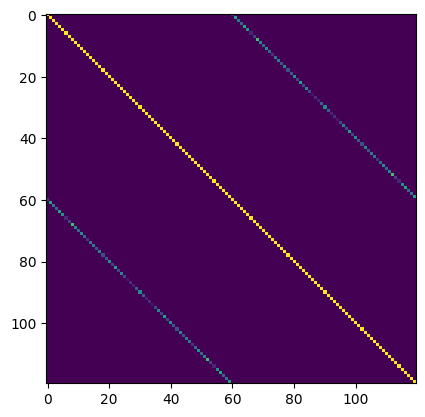

In [64]:
# frame operator

N = 120
D = 2
T = 60
J = 6

assert N % D == 0

w_fir = torch.randint(-1, 1, (J, T)).float()
w = torch.cat([w_fir, torch.zeros(J, N-T)], dim=1)
w = fir_tightener3000(w, T, eps=1.0001).real
w_fir = w[:, :T]

W = fb_analysis(w, D)
A, B = frame_bounds(w, D)
print(B/A)
S = (W.T @ W).to(torch.complex64)
# multiply dft matrix before and after the frame operator
DFT = torch.fft.fft(torch.eye(N))
S_hat = DFT @ S @ DFT.H

# plot the structure of the matrix above a certain threshold
#threshold = 0.001
#S[S.abs() < threshold] = 0
plt.imshow(torch.abs(S_hat))

In [73]:
w_hat = torch.fft.fft(w, dim=1)
diag = torch.sum(w_hat.abs() ** 2, dim=0)
A = torch.min(diag).item()
B = torch.max(diag).item()
kappa = B/A - 1

alias = torch.zeros(w_hat.shape)
hop = w.shape[1]//D
for j in range(1,D):
    alias += torch.abs(w_hat * torch.conj(torch.roll(w_hat, j * hop, 1)))
alias = torch.sum(alias, dim=0)

# minimize loss + beta * (kappa + alias)
